

## **SMS Spam Classifier: Training, Evaluation & Saving**

This section covers the steps to transform preprocessed SMS messages into a trained machine learning model for classification (`Transactional`, `Promotional`, `Spam`). It also demonstrates evaluation, visualization, and saving of the model and vectorizer.


### **1️⃣ Vectorization**

* Text messages are converted to numerical features using **TF-IDF**.
* N-grams (1-2) are used to capture single words and word pairs.
* Common English stopwords are removed.


### **2️⃣ Model Training**

* A **Logistic Regression** classifier is trained on the vectorized messages.
* Training is done on 80% of the dataset while keeping class balance.



### **3️⃣ Model Evaluation**

* The model is evaluated on the 20% test set.
* Metrics include **accuracy, precision, recall, and F1-score**.
* A **confusion matrix** is plotted to visualize performance per class.
* Colors and design of the confusion matrix can be adjusted for clarity.


### **4️⃣ Feature Importance & Probability Visualization**

* The model’s **top words per class** are visualized using bar charts based on coefficients.
* Predicted probability distributions for each class are plotted to see the model’s confidence.



### **5️⃣ Single Message Prediction**

* A function is provided to predict the category of **any new SMS message**.
* Returns both the **predicted class** and **confidence score**.



### **6️⃣ Model Saving**

* The trained model and vectorizer are saved for later use:

  * **Model:** `sms_classifier.pkl`
  * **Vectorizer:** `tfidf_vectorizer.pkl`
* Saved in the `models/` folder, ready for API integration.





In [5]:
# uploading thr preprocessed CSV dataset
from google.colab import files
import os

uploaded_files = files.upload()  # Upload CSV file
print("Files uploaded:", os.listdir())  # Check uploaded files


Saving labeled_sms_dataset_FINAL.csv to labeled_sms_dataset_FINAL.csv
Files uploaded: ['.config', 'labeled_sms_dataset_FINAL.csv', 'sample_data']


In [6]:
# Load the uploaded CSV into a DataFrame and inspect basic info
import pandas as pd

sms_df = pd.read_csv("labeled_sms_dataset_FINAL.csv")

print(f"Dataset Shape: {sms_df.shape}")  # Show dataset dimensions
print("\nCategory Distribution:")
print(sms_df['category'].value_counts())  # Check label balance
print("\nSample Rows:")
print(sms_df.head())  # Preview first 5 rows


Dataset Shape: (12060, 3)

Category Distribution:
category
Transactional    4020
Promotional      4020
Spam             4020
Name: count, dtype: int64

Sample Rows:
                                             message       category  \
0  Your transaction ID is TXN179896. Please keep ...  Transactional   
1  Check out our latest deals at https://secure.b...    Promotional   
2  Click here to win an iPhone: https://winfreeca...           Spam   
3  Your transaction ID is TXN418755. Please keep ...  Transactional   
4     Check out our latest deals at https://trip.com    Promotional   

                                     cleaned_message  
0  your transaction id is txn179896. please keep ...  
1  check out our latest deals at https://secure.b...  
2  click here to win an iphone: https://winfreeca...  
3  your transaction id is txn418755. please keep ...  
4     check out our latest deals at https://trip.com  


In [7]:
# Add extra features for analysis/uniqueness
sms_df['msg_length'] = sms_df['cleaned_message'].apply(len)  # Character count
sms_df['word_count'] = sms_df['cleaned_message'].apply(lambda x: len(x.split()))  # Word count
sms_df['num_links'] = sms_df['cleaned_message'].str.count(r'http[s]?://')  # Count URLs

print(sms_df.head())  # Preview new features


                                             message       category  \
0  Your transaction ID is TXN179896. Please keep ...  Transactional   
1  Check out our latest deals at https://secure.b...    Promotional   
2  Click here to win an iPhone: https://winfreeca...           Spam   
3  Your transaction ID is TXN418755. Please keep ...  Transactional   
4     Check out our latest deals at https://trip.com    Promotional   

                                     cleaned_message  msg_length  word_count  \
0  your transaction id is txn179896. please keep ...          66          11   
1  check out our latest deals at https://secure.b...          64           7   
2  click here to win an iphone: https://winfreeca...          52           7   
3  your transaction id is txn418755. please keep ...          66          11   
4     check out our latest deals at https://trip.com          46           7   

   num_links  
0          0  
1          1  
2          1  
3          0  
4          1  


In [8]:
# Split dataset into training and testing sets (80-20 split)
from sklearn.model_selection import train_test_split

X_texts = sms_df['cleaned_message']  # Features
y_labels = sms_df['category']        # Target labels

X_train, X_test, y_train, y_test = train_test_split(
    X_texts, y_labels,
    test_size=0.2,
    random_state=42,
    stratify=y_labels  # Maintain class balance
)

print(f"Train set: {len(X_train)} samples")
print(f"Test set : {len(X_test)} samples")


Train set: 9648 samples
Test set : 2412 samples


In [9]:
# Convert text to numerical vectors using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,     # Limit vocabulary
    ngram_range=(1,2),     # Include single words and pairs
    stop_words='english',  # Remove common stopwords
    lowercase=False        # Already lowercase
)

X_train_vect = tfidf_vectorizer.fit_transform(X_train)  # Fit on training
X_test_vect = tfidf_vectorizer.transform(X_test)        # Transform test

print(f"Vectorized data shape: {X_train_vect.shape}")


Vectorized data shape: (9648, 5000)


In [10]:
# Train a fast, lightweight Logistic Regression model for classification
from sklearn.linear_model import LogisticRegression

sms_classifier = LogisticRegression(max_iter=1000, random_state=42)

print("Training the model...")
sms_classifier.fit(X_train_vect, y_train)
print("Training completed!")


Training the model...
Training completed!


In [17]:
# Evaluate model performance on test set
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, roc_auc_score

# Predictions
y_pred_test = sms_classifier.predict(X_test_vect)
y_pred_proba = sms_classifier.predict_proba(X_test_vect)
# Basic metrics
acc = accuracy_score(y_test, y_pred_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

print(f"Accuracy  : {acc:.3f}")
print(f"Precision : {prec:.3f}")
print(f"Recall    : {rec:.3f}")
print(f"F1-Score  : {f1:.3f}\n")

# Detailed classification report
print("Detailed Classification Report:\n")
print(classification_report(y_test, y_pred_test))

# Macro ROC-AUC (OvR)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f"Macro ROC-AUC (OvR): {roc_auc:.4f}")


Accuracy  : 1.000
Precision : 1.000
Recall    : 1.000
F1-Score  : 1.000

Detailed Classification Report:

               precision    recall  f1-score   support

  Promotional       1.00      1.00      1.00       804
         Spam       1.00      1.00      1.00       804
Transactional       1.00      1.00      1.00       804

     accuracy                           1.00      2412
    macro avg       1.00      1.00      1.00      2412
 weighted avg       1.00      1.00      1.00      2412

Macro ROC-AUC (OvR): 1.0000


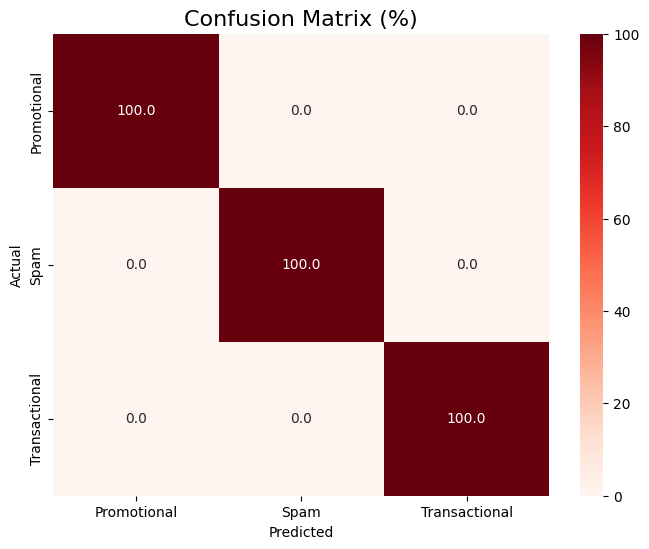

In [12]:
# Display confusion matrix with percentages
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred_test, labels=sms_classifier.classes_)
cm_percent = cm / cm.sum(axis=1)[:, None] * 100  # Convert to % for readability

plt.figure(figsize=(8,6))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Reds',
            xticklabels=sms_classifier.classes_, yticklabels=sms_classifier.classes_)
plt.title('Confusion Matrix (%)', fontsize=16)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


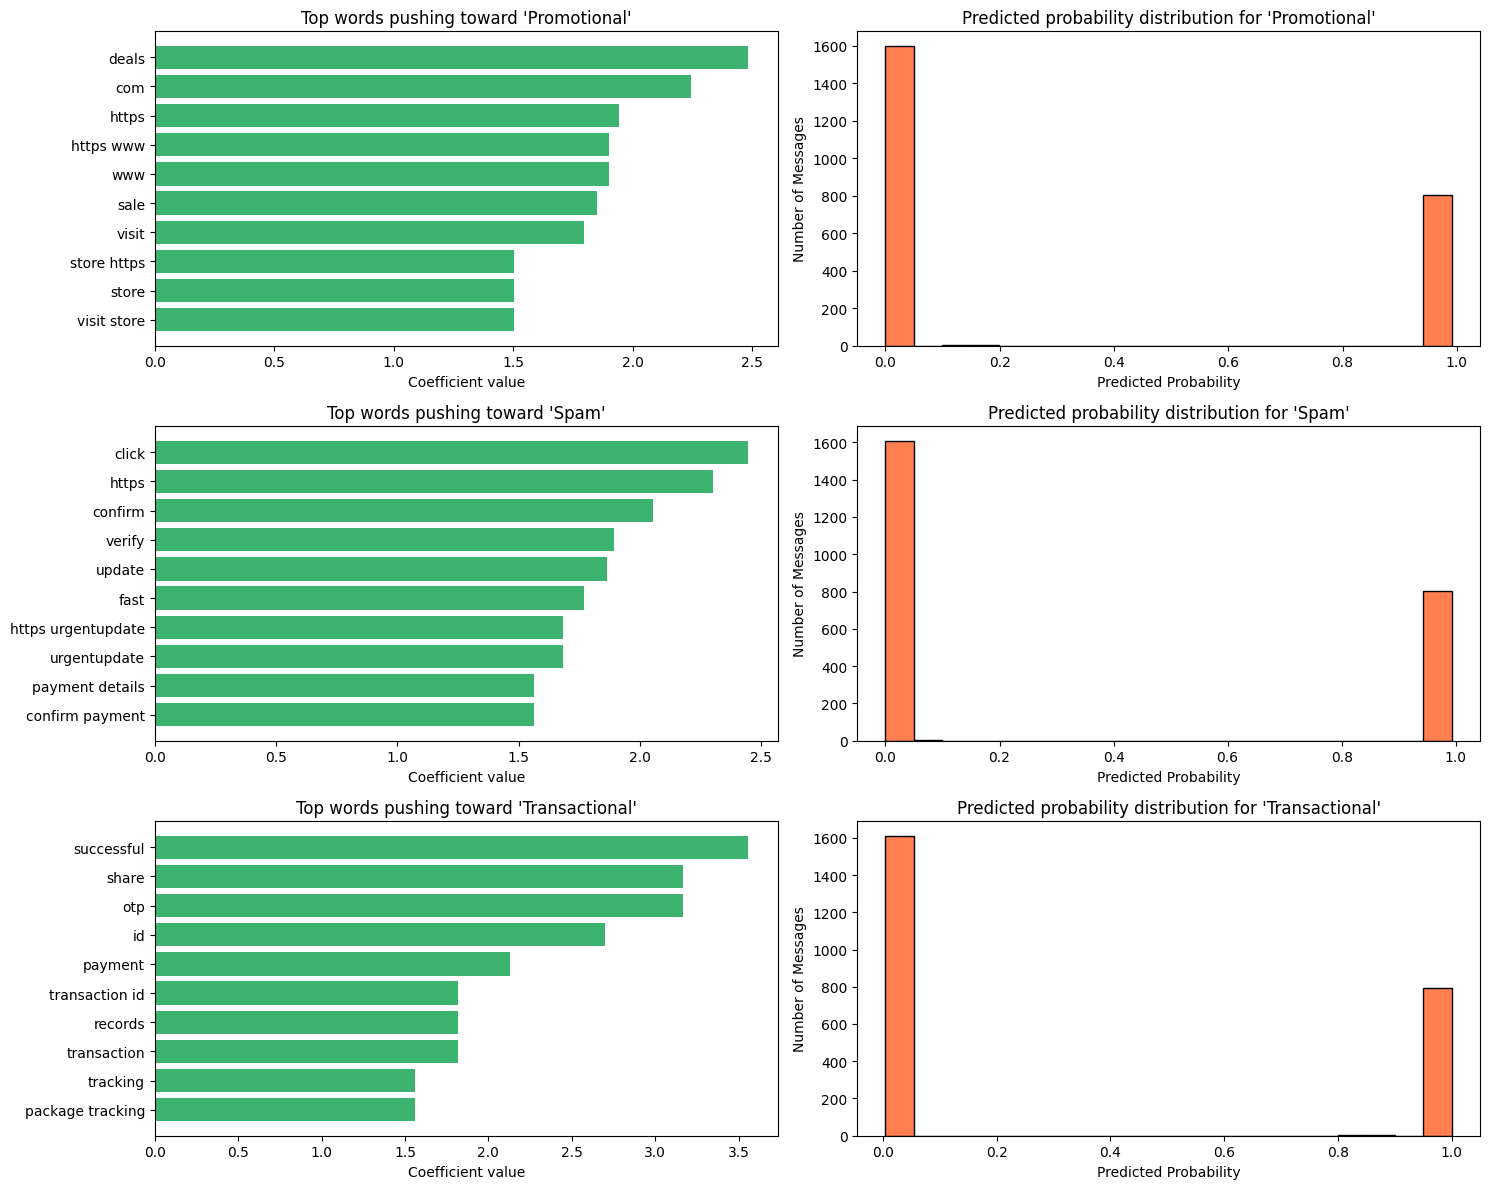

In [13]:
# This cell visualizes what the logistic regression model considers important
# and how confident it is in predictions

import matplotlib.pyplot as plt
import numpy as np

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Plot Top 10 words for each class based on coefficients
classes = sms_classifier.classes_
plt.figure(figsize=(15, 4 * len(classes)))

for i, cls in enumerate(classes):
    coef = sms_classifier.coef_[i]
    top_idx = np.argsort(coef)[-10:]  # Top 10 positive coefficients
    plt.subplot(len(classes), 2, 2*i + 1)
    plt.barh(np.array(feature_names)[top_idx], coef[top_idx], color='mediumseagreen')
    plt.title(f"Top words pushing toward '{cls}'")
    plt.xlabel("Coefficient value")
    plt.tight_layout()

    # Plot histogram of predicted probabilities for this class
    proba_cls = sms_classifier.predict_proba(X_test_vect)[:, i]
    plt.subplot(len(classes), 2, 2*i + 2)
    plt.hist(proba_cls, bins=20, color='coral', edgecolor='black')
    plt.title(f"Predicted probability distribution for '{cls}'")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Number of Messages")

plt.show()


In [14]:
# Function to predict category of a single message with confidence
import re

def predict_message(msg_text):
    cleaned = re.sub(r'\s+', ' ', msg_text.lower().strip())  # Clean text
    vect = tfidf_vectorizer.transform([cleaned])             # Vectorize
    pred = sms_classifier.predict(vect)[0]                  # Predict label
    prob = sms_classifier.predict_proba(vect)[0]            # Probabilities
    confidence = max(prob)
    return pred, confidence

# Test samples
test_msgs = [
    "Your OTP is 987654. Do not share it with anyone.",
    "You won a lottery! Click https://scam.com",
    "Limited time deals at https://shopnow.com"
]

for m in test_msgs:
    label, conf = predict_message(m)
    print(f"Message: '{m}'\nPrediction: {label}, Confidence: {conf:.2f}\n")


Message: 'Your OTP is 987654. Do not share it with anyone.'
Prediction: Transactional, Confidence: 1.00

Message: 'You won a lottery! Click https://scam.com'
Prediction: Spam, Confidence: 0.94

Message: 'Limited time deals at https://shopnow.com'
Prediction: Promotional, Confidence: 0.96



In [15]:
import joblib
import os
from google.colab import files

# Create folder if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save trained model and vectorizer
joblib.dump(sms_classifier, 'models/sms_classifier.pkl')
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')

# Download files to local machine
files.download('models/sms_classifier.pkl')
files.download('models/tfidf_vectorizer.pkl')

print("Model and vectorizer saved successfully!")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model and vectorizer saved successfully!
